In [1]:
from transformers import AutoModelForMaskedLM, TrainingArguments, Trainer, AutoTokenizer
import torch

# from lava import LavaModelSmall
# model = LavaModelSmall.from_lava_pretrained('roberta-base', 'facebook/bart-base')

from utils.datasets_config import get_dataset

dset = get_dataset('gigaword', 'facebook/bart-base')
print(dset)

tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')


from lava import LavaModel
model = LavaModel.from_pretrained('cestwc/lava-small-gigaword').cuda().eval()

Found cached dataset gigaword (/home/azureuser/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/azureuser/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-ec2f04cbc5a64a59.arrow
Loading cached processed dataset at /home/azureuser/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-f10e57b03c68e54b.arrow
Loading cached processed dataset at /home/azureuser/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-b8e4fbcfe3300933.arrow


Number of gigaword training examples: 3803957
Number of gigaword validation examples: 189651
Number of gigaword testing examples: 1951
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 3803957
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 189651
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 1951
    })
})


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


In [2]:
def collate(batch):
    batch = ({k: torch.nn.utils.rnn.pad_sequence([dic[k] for dic in batch], batch_first=True, padding_value=1) for k in batch[0]})
    batch['input_ids'][batch['input_ids'] == 2] = 0
    batch['attention_mask'] = (batch['input_ids'] != 1).long()
    batch['labels'][batch['labels']==1] = -100
#     batch['labels'] = torch.nn.functional.pad(batch['labels'], (0, batch['input_ids'].shape[1] - batch['labels'].shape[1], 0, 0), 'constant', 1)
    return batch

In [3]:
trainer = Trainer(
    model = model,
#     args = training_args,
    train_dataset = dset['train'].shuffle(1234),
    eval_dataset = dset['test'],
    data_collator = collate,
    # compute_metrics = lambda x: print(x),
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=7)],
)


Loading cached shuffled indices for dataset at /home/azureuser/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-b72e92e25248f7d5.arrow


In [4]:
# trainer._load_from_checkpoint('lava-ce/checkpoint-2000000')

In [5]:
# trainer.evaluate()

In [30]:
dset['validation']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
    num_rows: 189651
})

In [32]:
def predict(e):
    with torch.no_grad():
        output = model(
            input_ids = e['input_ids'].to(model.device).unsqueeze(0),
            attention_mask = e['attention_mask'].to(model.device).unsqueeze(0),
            generate = True
        )
    e['output_ids'] = output.logits.argmax(2).tolist()[0]
    e['output_texts'] = tokenizer.decode(e['output_ids'], skip_special_tokens=True)
    return e

test_data_tagged = dset['train'].shard(3000, 0).map(predict, batched=False)

  0%|          | 0/1268 [00:00<?, ?ex/s]

In [33]:
import numpy as np
from rouge_score import rouge_scorer

# dir = drivePath + 'cnndm-test-result-ternary.json'
# with open(dir, 'r') as f:
#     data = [json.loads(x) for x in f.readlines()]

references = test_data_tagged['label_texts']
predictions = test_data_tagged['output_texts']

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeLsum'], use_stemmer=True)

ROUGE = [scorer.score(references[i], predictions[i]) for i in range(len(predictions))]

print(np.mean([x['rouge1'].fmeasure for x in ROUGE]))
print(np.mean([x['rouge2'].fmeasure for x in ROUGE]))
print(np.mean([x['rougeLsum'].fmeasure for x in ROUGE]))

0.22204442003566194
0.047411854449338216
0.20942764525015406


In [28]:
test_data_tagged['output_texts']

['necK announce forces',
 'government closes government schools',
 'police five nuclear protesters',
 'us goods orders up',
 'bo urges market markets',
 'UN world news summary',
 'af world news summary',
 'pafp world news summary',
 'ind sparks sparks reaction',
 '',
 'm for parliamentary elections',
 'af world news summary',
 'opp opposition polish president',
 'rand ground against dollar',
 'af world news summary',
 'terror suspect suspect summary',
 'af air news summary',
 'sp gets suspended sentence',
 'af world cup summary',
 'f name unchanged team',
 'UN # q #',
 '## in plane crash',
 'tight candidates presidential begins',
 'un world children children',
 ' soldierun soldier killed in accident',
 'af denies news extradition',
 'west wife in wife',
 'pafp world news summary',
 'ro world with democracy',
 'man for killing murder',
 'clinton new budget plan',
 'five leave french embassy',
 'UN repatri refugees postponed',
 'atl separate from mir',
 'down down government offensive',


In [34]:
test_data_tagged['output_texts']

['af world news summary',
 'af music festival ##',
 'l stocks lose ground',
 'c leaves bosnia',
 'oil continue to slide',
 'pafp world news summary',
 'af world news summary',
 'band murdera dismissed',
 'police federal tax building',
 'eve world news agenda',
 'b world condemns attack',
 'r media under probe',
 'eu afghan aid',
 'stocks at wall opening',
 'ever handed tricky tie',
 'us oil stocks slump',
 'us divided court justice',
 'ind separatists announce ceasefire',
 'ag stays the results',
 'home takes provisional pace',
 'tur presses educational reform',
 'af world news summary',
 'wild delegates with issues',
 'security under heavy security',
 'fire firefighters second strike',
 'af world news summary',
 'police ## illegal immigrants',
 'security demands rebel rebels',
 'profit ends early surge',
 'fox spurs move',
 'mand amnesty amnesty amnesty',
 'fighting bomb bombing village',
 'n destroys rebel boats',
 'UN winsK contract',
 'rw board board begins',
 'foreign foreign fore

In [35]:
test_data_tagged['label_texts']

['australian current account deficit narrows sharply',
 'iceland rock fest ups roots goes to london for ##th birthday',
 'london stocks shed #.# percent on day',
 'carter leaves frankfurt for zagreb',
 'oil dips further due to warm us weather',
 'australian stocks close #.## percent higher on resources banks',
 'fda clears impotence drug cialis a new viagra rival',
 'court orders murder case against banda companion to proceed',
 'police detonate bomb placed near nevada federal building',
 'fifty years on hillary and tenzing to scale mount everest again',
 'britain condemns pakistan church attack',
 'russian prosecutors launch probe into berezovsky editor',
 'eu urges afghanistan to put economic house in order',
 'stocks flat at wall street opening',
 'everton handed tricky tie in english league cup second round',
 'us oil inventories show heavy toll of katrina',
 'us senate democrats divided over roberts nomination for supreme court chief',
 "rebel group accepts ceasefire offer in indi

In [6]:
d = next(iter(dset['train'].shard(300, 1).shuffle()))
decoder_input_ids = (d['labels'] == 1).long()

Loading cached shuffled indices for dataset at /home/azureuser/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-92e797154ba25e06.arrow


In [7]:
o = model(
    input_ids = d['input_ids'].cuda().unsqueeze(0),
    attention_mask = d['attention_mask'].cuda().unsqueeze(0),
    generate = True
)

In [8]:
d

{'input_ids': tensor([    0,   397, 17419, 10409,    34,  4768,   690,    14,   169,   858,
          4533,  6071,    40,    28,  1088,    11,     5, 10408, 16705,  2937,
          2931,  1437,  1437,   511, 18898,  6116,    59,     5,  5955,  1437,
           579,   499,    23,     5,   950,  1437,  1437,     2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor([    0, 33557,  9118,   708,     7,  1331,  4533,  6071,     2])}

In [9]:
o.logits.argmax(2)

tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 33557,
             0,  4533,  6071,  8762,     2]], device='cuda:0')

In [16]:
tokenizer.decode(o.logits.argmax(2).tolist()[0], skip_special_tokens=True)


'united rooney rumors'

In [11]:
print(tokenizer.decode(d['input_ids'], skip_special_tokens=True))
print()
print(tokenizer.decode(d['labels'], skip_special_tokens=True))

manchester united has dismissed reports that wayne rooney will be sold in the january transfer window   following rampant speculation about the striker  s future at the club  

united denies plans to sell rooney


In [12]:
scores = model.decoder(input_ids = d['input_ids'].cuda().unsqueeze(0), decoder_input_ids = 50264 * torch.ones_like(d['input_ids']).cuda().unsqueeze(0)).end_logits
scores

tensor([[-3.6925, -5.5269, -5.5113, -4.0515, -4.1184, -0.6773, -0.7303,  1.1776,
          2.8540,  3.8152,  4.3044,  4.8758,  5.3149,  5.2120,  4.9470,  5.3463,
          5.5964,  5.7420,  5.8916,  5.9187,  5.7672,  5.7794,  5.6632,  5.5926,
          5.5555,  5.5234,  5.5260,  5.6884,  5.4674,  5.5135,  5.5757,  5.4896,
          5.5796,  5.6184,  5.5918,  5.5302,  5.6353,  5.6733]],
       device='cuda:0', grad_fn=<CloneBackward0>)

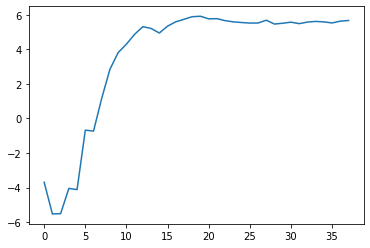

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(scores.tolist()[0])

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 181,421,145 trainable parameters


In [15]:
model.decoder(input_ids = d['input_ids'].cuda().unsqueeze(0), decoder_input_ids = 50264 * torch.ones_like(d['input_ids']).cuda().unsqueeze(0)).end_logits

tensor([[-3.6925, -5.5269, -5.5113, -4.0515, -4.1184, -0.6773, -0.7303,  1.1776,
          2.8540,  3.8152,  4.3044,  4.8758,  5.3149,  5.2120,  4.9470,  5.3463,
          5.5964,  5.7420,  5.8916,  5.9187,  5.7672,  5.7794,  5.6632,  5.5926,
          5.5555,  5.5234,  5.5260,  5.6884,  5.4674,  5.5135,  5.5757,  5.4896,
          5.5796,  5.6184,  5.5918,  5.5302,  5.6353,  5.6733]],
       device='cuda:0', grad_fn=<CloneBackward0>)